In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import random
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_full = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
testset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)

In [ ]:
train_data, val_data = torch.utils.data.random_split(trainset_full, [50000, 10000])

valloader = DataLoader(val_data, batch_size = 128, shuffle = False)
testloader = DataLoader(testset, batch_size = 128, shuffle = False)


In [ ]:
num_clients = 10

def partition_data(dataset, num_clients):
    client_data = {i: [] for i in range(num_clients)}

    indices = np.random.permutation(len(dataset))
    client_size = len(dataset) // num_clients

    for i in range(num_clients):
        client_indices = indices[i * client_size : (i + 1) * client_size]
        client_data[i] = torch.utils.data.Subset(dataset, client_indices)

    return client_data


# def partition_data(dataset, num_clients, shards_per_client = 5):
#     labels = np.array(dataset.dataset.targets)[dataset.indices]
#     indices = np.argsort(labels)
#     num_shards = num_clients * shards_per_client
#     shard_size = len(dataset) // num_shards

#     shards = [indices[i * shard_size:(i + 1) * shard_size] for i in range(num_shards)]
#     np.random.shuffle(shards)

#     client_data = {}
#     for i in range(num_clients):
#         assigned_shards = shards[i * shards_per_client:(i + 1) * shards_per_client]
#         client_indices = np.concatenate(assigned_shards)
#         client_data[i] = torch.utils.data.Subset(dataset, client_indices)

#     return client_data


client_train_data = partition_data(train_data, num_clients)
print(f"Data partitioned for {len(client_train_data)} clients.")

Data partitioned for 10 clients.


In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def federated_averaging(global_model, local_models, local_weights):
    global_dict = global_model.state_dict()

    for key in global_dict.keys():
        global_dict[key] = torch.zeros_like(global_dict[key])

    total_weight = sum(local_weights)

    for (model, weight) in zip(local_models, local_weights):
        for key in global_dict.keys():
            global_dict[key] += model.state_dict()[key] * (weight / total_weight)

    global_model.load_state_dict(global_dict)
    return global_model


def train_local_model(model, train_loader, epochs, learning_rate):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()

    num_steps = 0 ;

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            num_steps += 1

    return model, num_steps


def federated_nova_aggregation(global_model, local_models, local_weights, local_steps):
    global_dict = global_model.state_dict()

    norm_delta_sum = {key: torch.zeros_like(val) for key, val in global_dict.items()}
    total_weight = sum(local_weights)

    tau_effective = 0.0

    for (model, weight, steps) in zip(local_models, local_weights, local_steps):
        local_dict = model.state_dict()
        client_weight = weight / total_weight

        for key in global_dict.keys():
            delta = local_dict[key] - global_dict[key]
            norm_delta = delta / (steps + 1e-8)
            norm_delta_sum[key] += norm_delta * client_weight

        tau_effective += client_weight * steps

    updated_global_dict = {}

    for key in global_dict.keys():
        updated_global_dict[key] = global_dict[key] + tau_effective * norm_delta_sum[key]

    global_model.load_state_dict(updated_global_dict)

    return global_model


def plot_confusion_matrix(cm, classes, title = 'Confusion Matrix'):
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)

    plt.figure(figsize = (8, 6))

    sns.heatmap(cm_df, annot = True, cmap = "Blues", fmt = 'g')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def evaluate_model(model, data_loader, class_names, plot_cm = False):
    model.eval()
    model.to(device)

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(targets.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))
    precision = precision_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)
    recall = recall_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)
    f1 = f1_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)

    if plot_cm:
        cm = confusion_matrix(true_labels, pred_labels)
        plot_confusion_matrix(cm, class_names)

    return accuracy, precision, recall, f1

In [ ]:
def federated_training(global_model, client_data, valloader, num_rounds, learning_rate, batch_size):
    val_accuracy_history = []
    val_f1_history = []
    class_names = [str(i) for i in range(10)]

    for round_num in range(num_rounds):
        local_models, local_weights, local_steps = [], [], []

        selected_clients = list(client_data.keys())

        for client_id in selected_clients:
            client_model = Model().to(device)
            client_model.load_state_dict(global_model.state_dict())

            client_train_loader = DataLoader(client_data[client_id], batch_size = batch_size, shuffle = True)

            epochs_for_this_client = random.randint(3, 5)
            trained_model, num_steps = train_local_model(client_model, client_train_loader, epochs_for_this_client, learning_rate)

            local_models.append(trained_model)
            local_weights.append(len(client_data[client_id]))

            local_steps.append(num_steps)

        global_model = federated_nova_aggregation(global_model, local_models, local_weights, local_steps)

        val_acc, val_prec, val_rec, val_f1 = evaluate_model(global_model, valloader, class_names)
        val_accuracy_history.append(val_acc)
        val_f1_history.append(val_f1)

        print(f"Round {round_num+1}/{num_rounds} | Validation Accuracy: {val_acc*100:.2f}% | Validation F1-Score: {val_f1:.4f}")

    return global_model, val_accuracy_history, val_f1_history

In [ ]:
NUM_ROUNDS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 64

global_model = Model().to(device)

print("--- Starting Federated Training ---")
final_model, val_acc_history, val_f1_history = federated_training(
    global_model,
    client_train_data,
    valloader,
    num_rounds = NUM_ROUNDS,
    learning_rate = LEARNING_RATE,
    batch_size = BATCH_SIZE
)

print("--- Federated Training Finished ---")



--- Starting Federated Training ---
Round 1/5 | Validation Accuracy: 28.34% | Validation F1-Score: 0.2429
Round 2/5 | Validation Accuracy: 50.48% | Validation F1-Score: 0.4404
Round 3/5 | Validation Accuracy: 59.58% | Validation F1-Score: 0.5367
Round 4/5 | Validation Accuracy: 64.47% | Validation F1-Score: 0.6067
Round 5/5 | Validation Accuracy: 67.38% | Validation F1-Score: 0.6486
--- Federated Training Finished ---


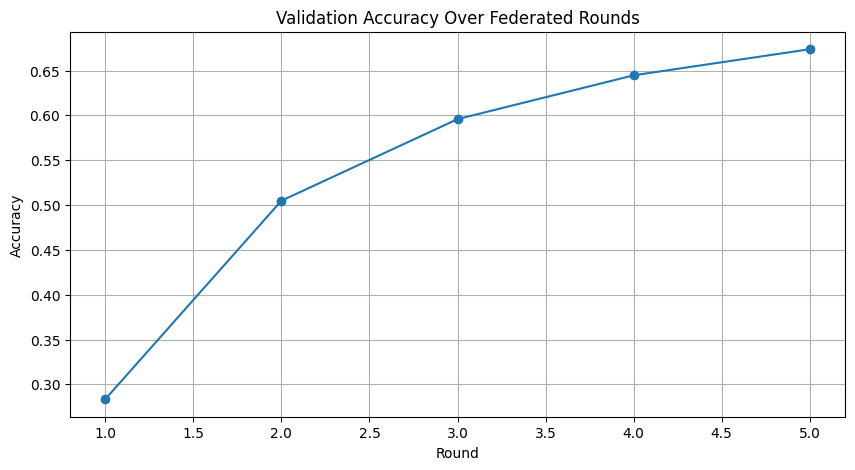


--- Evaluating Final Model on Test Set ---


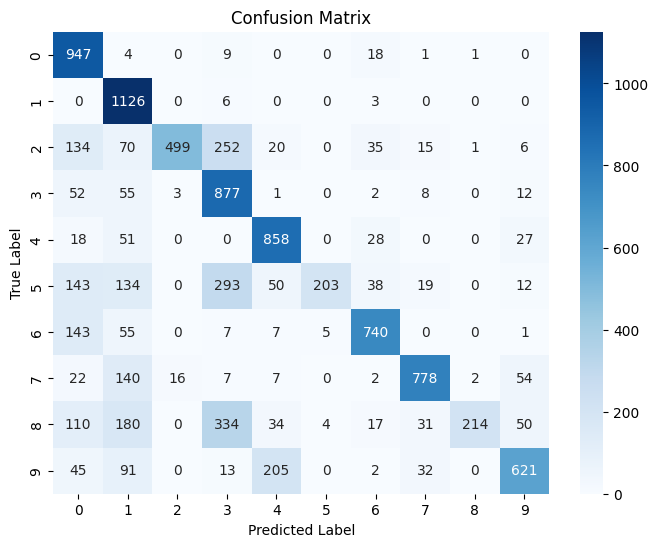

Final Test Accuracy: 68.63%
Final Test Precision: 0.7761
Final Test Recall: 0.6863
Final Test F1-Score: 0.6613


In [ ]:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, NUM_ROUNDS + 1), val_acc_history, marker='o')
    plt.title("Validation Accuracy Over Federated Rounds")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()


    print("\n--- Evaluating Final Model on Test Set ---")
    class_names = [str(i) for i in range(10)]
    test_acc, test_prec, test_rec, test_f1 = evaluate_model(final_model, testloader, class_names, plot_cm=True)

    print(f"Final Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Final Test Precision: {test_prec:.4f}")
    print(f"Final Test Recall: {test_rec:.4f}")
    print(f"Final Test F1-Score: {test_f1:.4f}")

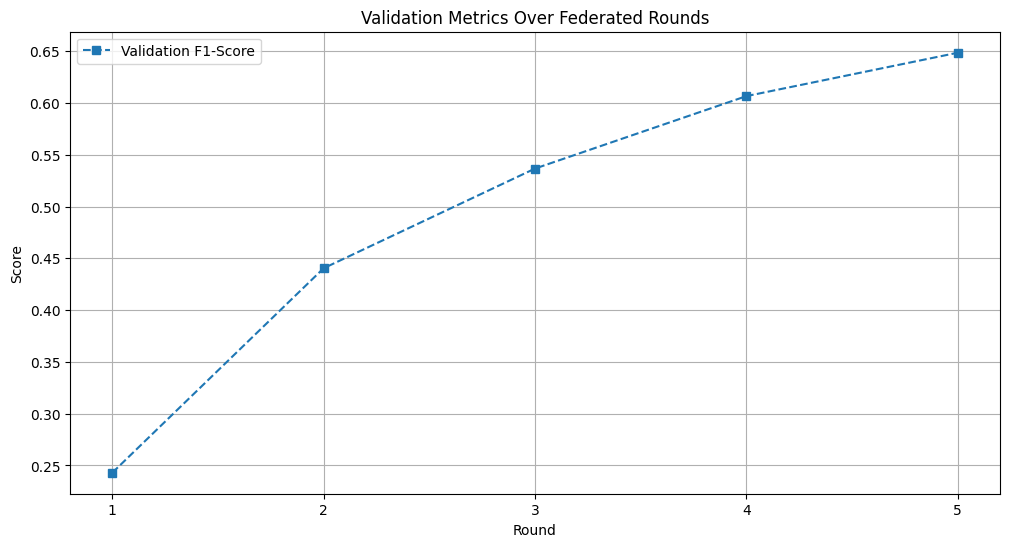

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(range(1, NUM_ROUNDS + 1), val_f1_history, marker='s', linestyle='--', label='Validation F1-Score')

plt.title("Validation Metrics Over Federated Rounds")
plt.xlabel("Round")
plt.ylabel("Score")
plt.xticks(range(1, NUM_ROUNDS + 1))
plt.grid(True)
plt.legend()
plt.show()